# Color Thresholding for Lane Detection

## Purpose
This notebook explores color-based segmentation techniques to isolate lane lines from road images. Lane lines are typically white or yellow, making color thresholding in HSV space an effective first step in the detection pipeline.

## Workflow
1. **Load and display test frame** - Select a sample frame and apply ROI mask
2. **Convert to HSV color space** - Better for color-based segmentation than RGB/BGR
3. **White lane detection** - Threshold for white lane markings (high Value, low Saturation)
4. **Yellow lane detection** - Threshold for yellow lane markings (Hue ~20-30°)
5. **Combine masks** - Merge white and yellow detections
6. **Apply within ROI** - Focus only on the road area

## Goal
Find HSV threshold values that reliably detect both white and yellow lane lines across different lighting conditions while minimizing false positives.

## 1. Load Frame and Apply ROI
Import the ROI function from previous notebook and apply it to our test frame

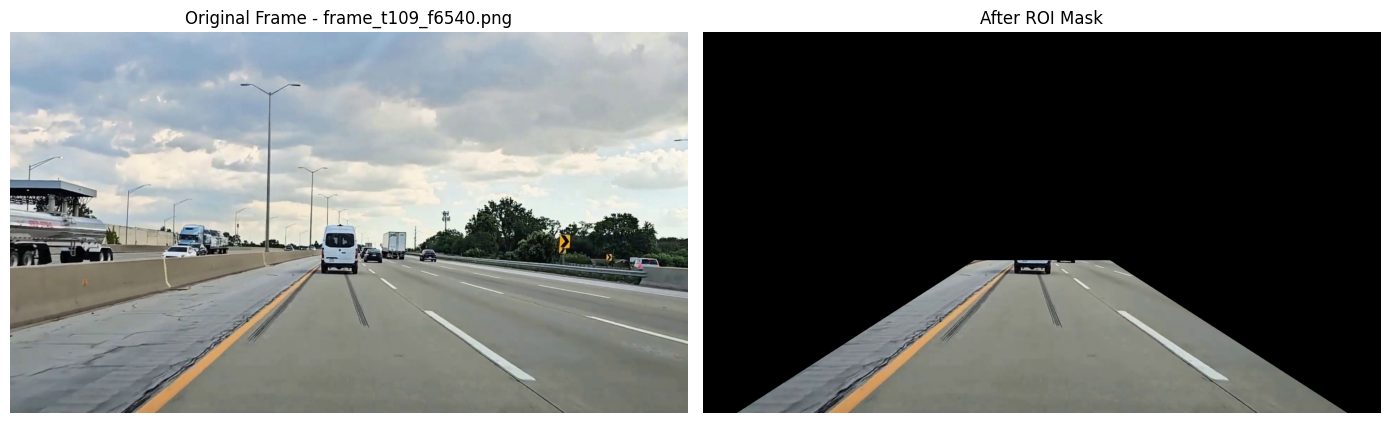

In [32]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# Add src directory to path to import pipeline functions
sys.path.insert(0, os.path.abspath('../src'))
from pipeline import apply_roi_mask

# Load first ROI test frame
frames_dir = "../data/frames_sample"
frame_name = "frame_t109_f6540.png"
img = cv2.imread(os.path.join(frames_dir, frame_name))

# Apply ROI
img_roi, roi_pts = apply_roi_mask(img)

# Display original and ROI
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0].set_title(f"Original Frame - {frame_name}")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(img_roi, cv2.COLOR_BGR2RGB))
axes[1].set_title("After ROI Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## 2. Convert to HSV and Explore Channels
HSV is better for color segmentation: Hue=color, Saturation=intensity, Value=brightness

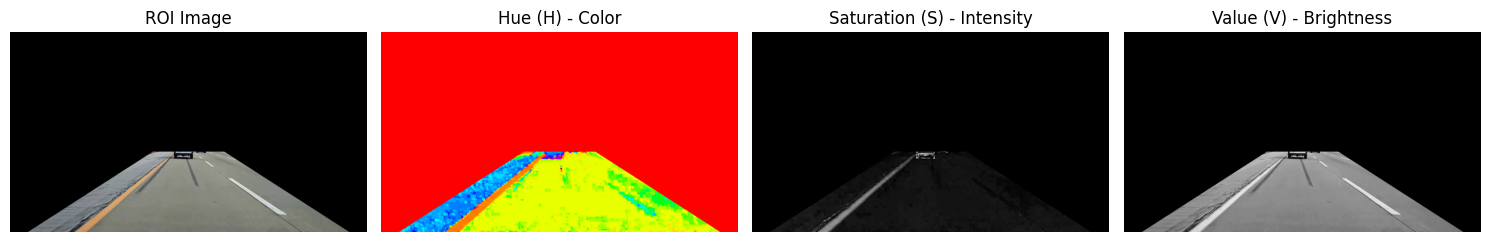

In [33]:
# Convert ROI image to HSV
img_hsv = cv2.cvtColor(img_roi, cv2.COLOR_BGR2HSV)

h, s, v = cv2.split(img_hsv)

plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(img_roi, cv2.COLOR_BGR2RGB))
plt.title("ROI Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(h, cmap="hsv")
plt.title("Hue (H) - Color")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(s, cmap="gray")
plt.title("Saturation (S) - Intensity")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(v, cmap="gray")
plt.title("Value (V) - Brightness")
plt.axis("off")

plt.tight_layout()
plt.show()

## 3. Detect White Lane Lines
White has high Value (brightness) and low Saturation (not colorful)

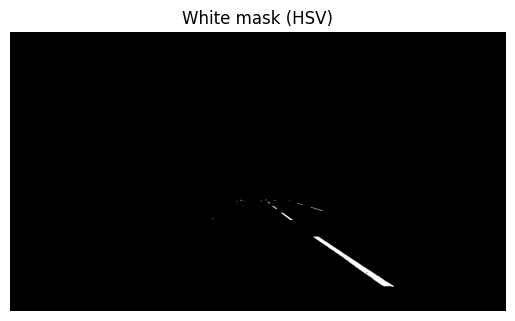

In [34]:
lower_white = np.array([0, 0, 200])
upper_white = np.array([180, 30, 255])

mask_white = cv2.inRange(img_hsv, lower_white, upper_white)

plt.imshow(mask_white, cmap="gray")
plt.title("White mask (HSV)")
plt.axis("off")
plt.show()

## 4. Detect Yellow Lane Lines
Yellow has Hue around 15-35° in HSV (greenish-yellow to orange-yellow)

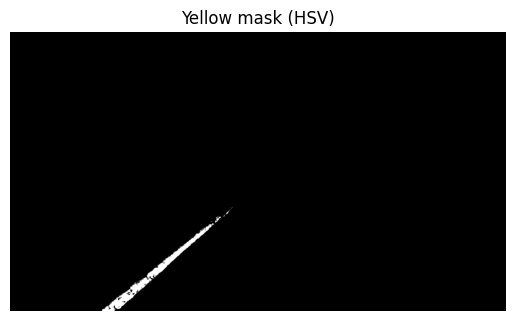

In [35]:
lower_yellow = np.array([15, 80, 80])
upper_yellow = np.array([35, 255, 255])

mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)

plt.imshow(mask_yellow, cmap="gray")
plt.title("Yellow mask (HSV)")
plt.axis("off")
plt.show()

## 5. Combine White and Yellow Masks
Merge both detections to get all lane lines

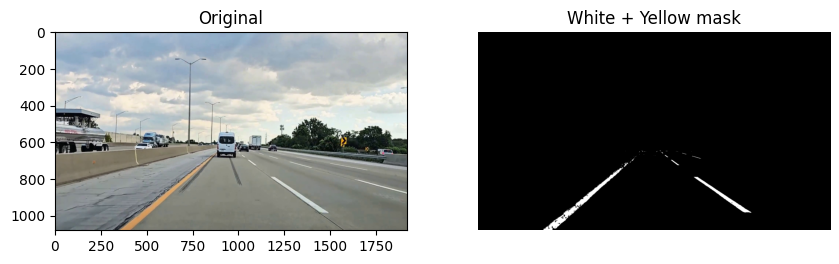

In [36]:
lane_mask = cv2.bitwise_or(mask_white, mask_yellow)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(lane_mask, cmap="gray")
plt.title("White + Yellow mask")
plt.axis("off")
plt.show()

## 6. Apply Combined Mask to ROI Only
Overlay the lane mask on the original image within ROI to see final detection

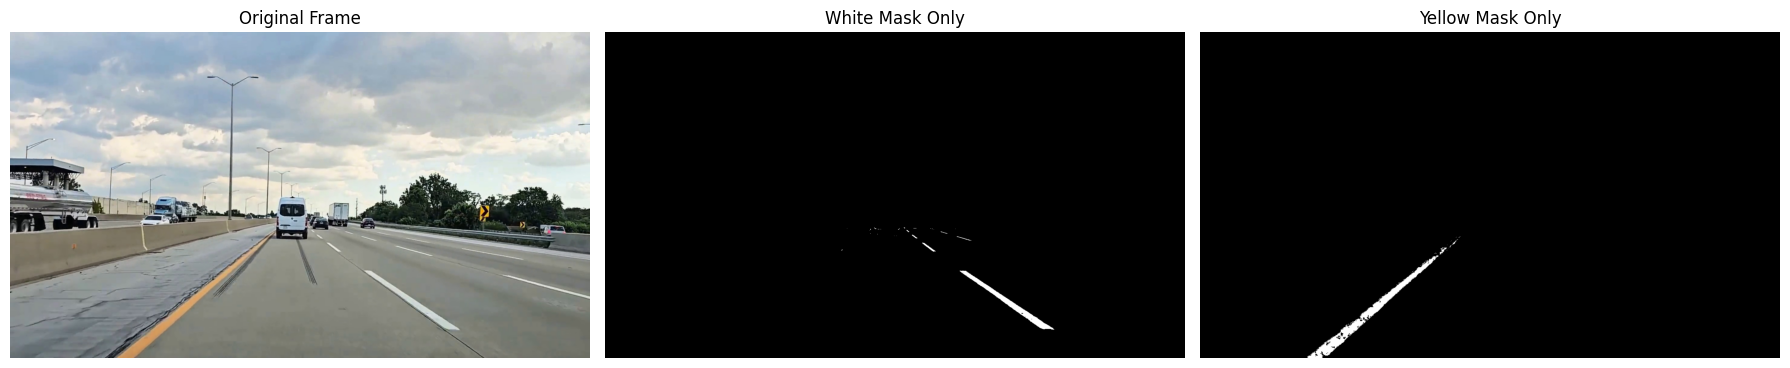

In [37]:
# Display combined mask results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Frame")
axes[0].axis("off")

axes[1].imshow(mask_white, cmap="gray")
axes[1].set_title("White Mask Only")
axes[1].axis("off")

axes[2].imshow(mask_yellow, cmap="gray")
axes[2].set_title("Yellow Mask Only")
axes[2].axis("off")

plt.tight_layout()
plt.show()

## 7. Morphological Cleaning (Optional)
Remove noise using opening (erosion+dilation) and fill gaps using closing (dilation+erosion)

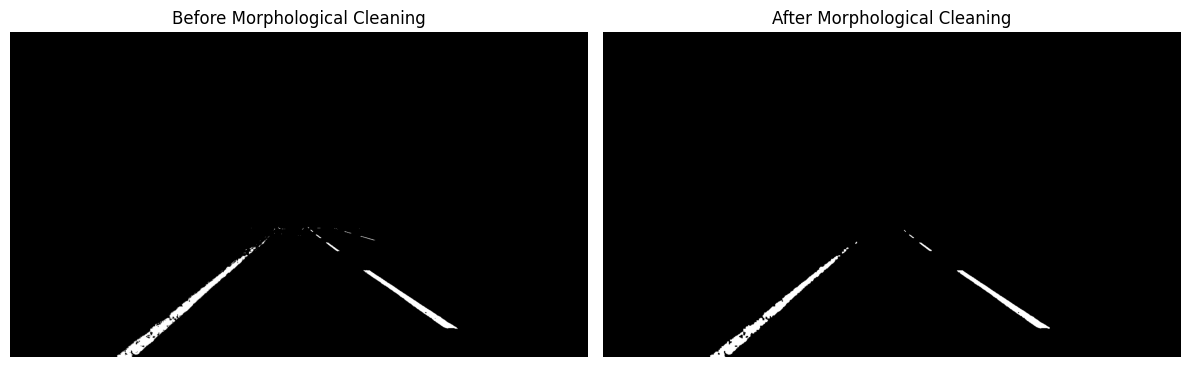

In [38]:
# Create morphological kernel
kernel = np.ones((3, 3), np.uint8)

# Opening: removes small noise (erosion followed by dilation)
lane_mask_clean = cv2.morphologyEx(lane_mask, cv2.MORPH_OPEN, kernel, iterations=1)

# Closing: fills small gaps (dilation followed by erosion)
lane_mask_clean = cv2.morphologyEx(lane_mask_clean, cv2.MORPH_CLOSE, kernel, iterations=1)

# Compare before and after cleaning
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(lane_mask, cmap="gray")
axes[0].set_title("Before Morphological Cleaning")
axes[0].axis("off")

axes[1].imshow(lane_mask_clean, cmap="gray")
axes[1].set_title("After Morphological Cleaning")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## 8. Test on Frames
Apply the color thresholding pipeline to test frames to validate consistency

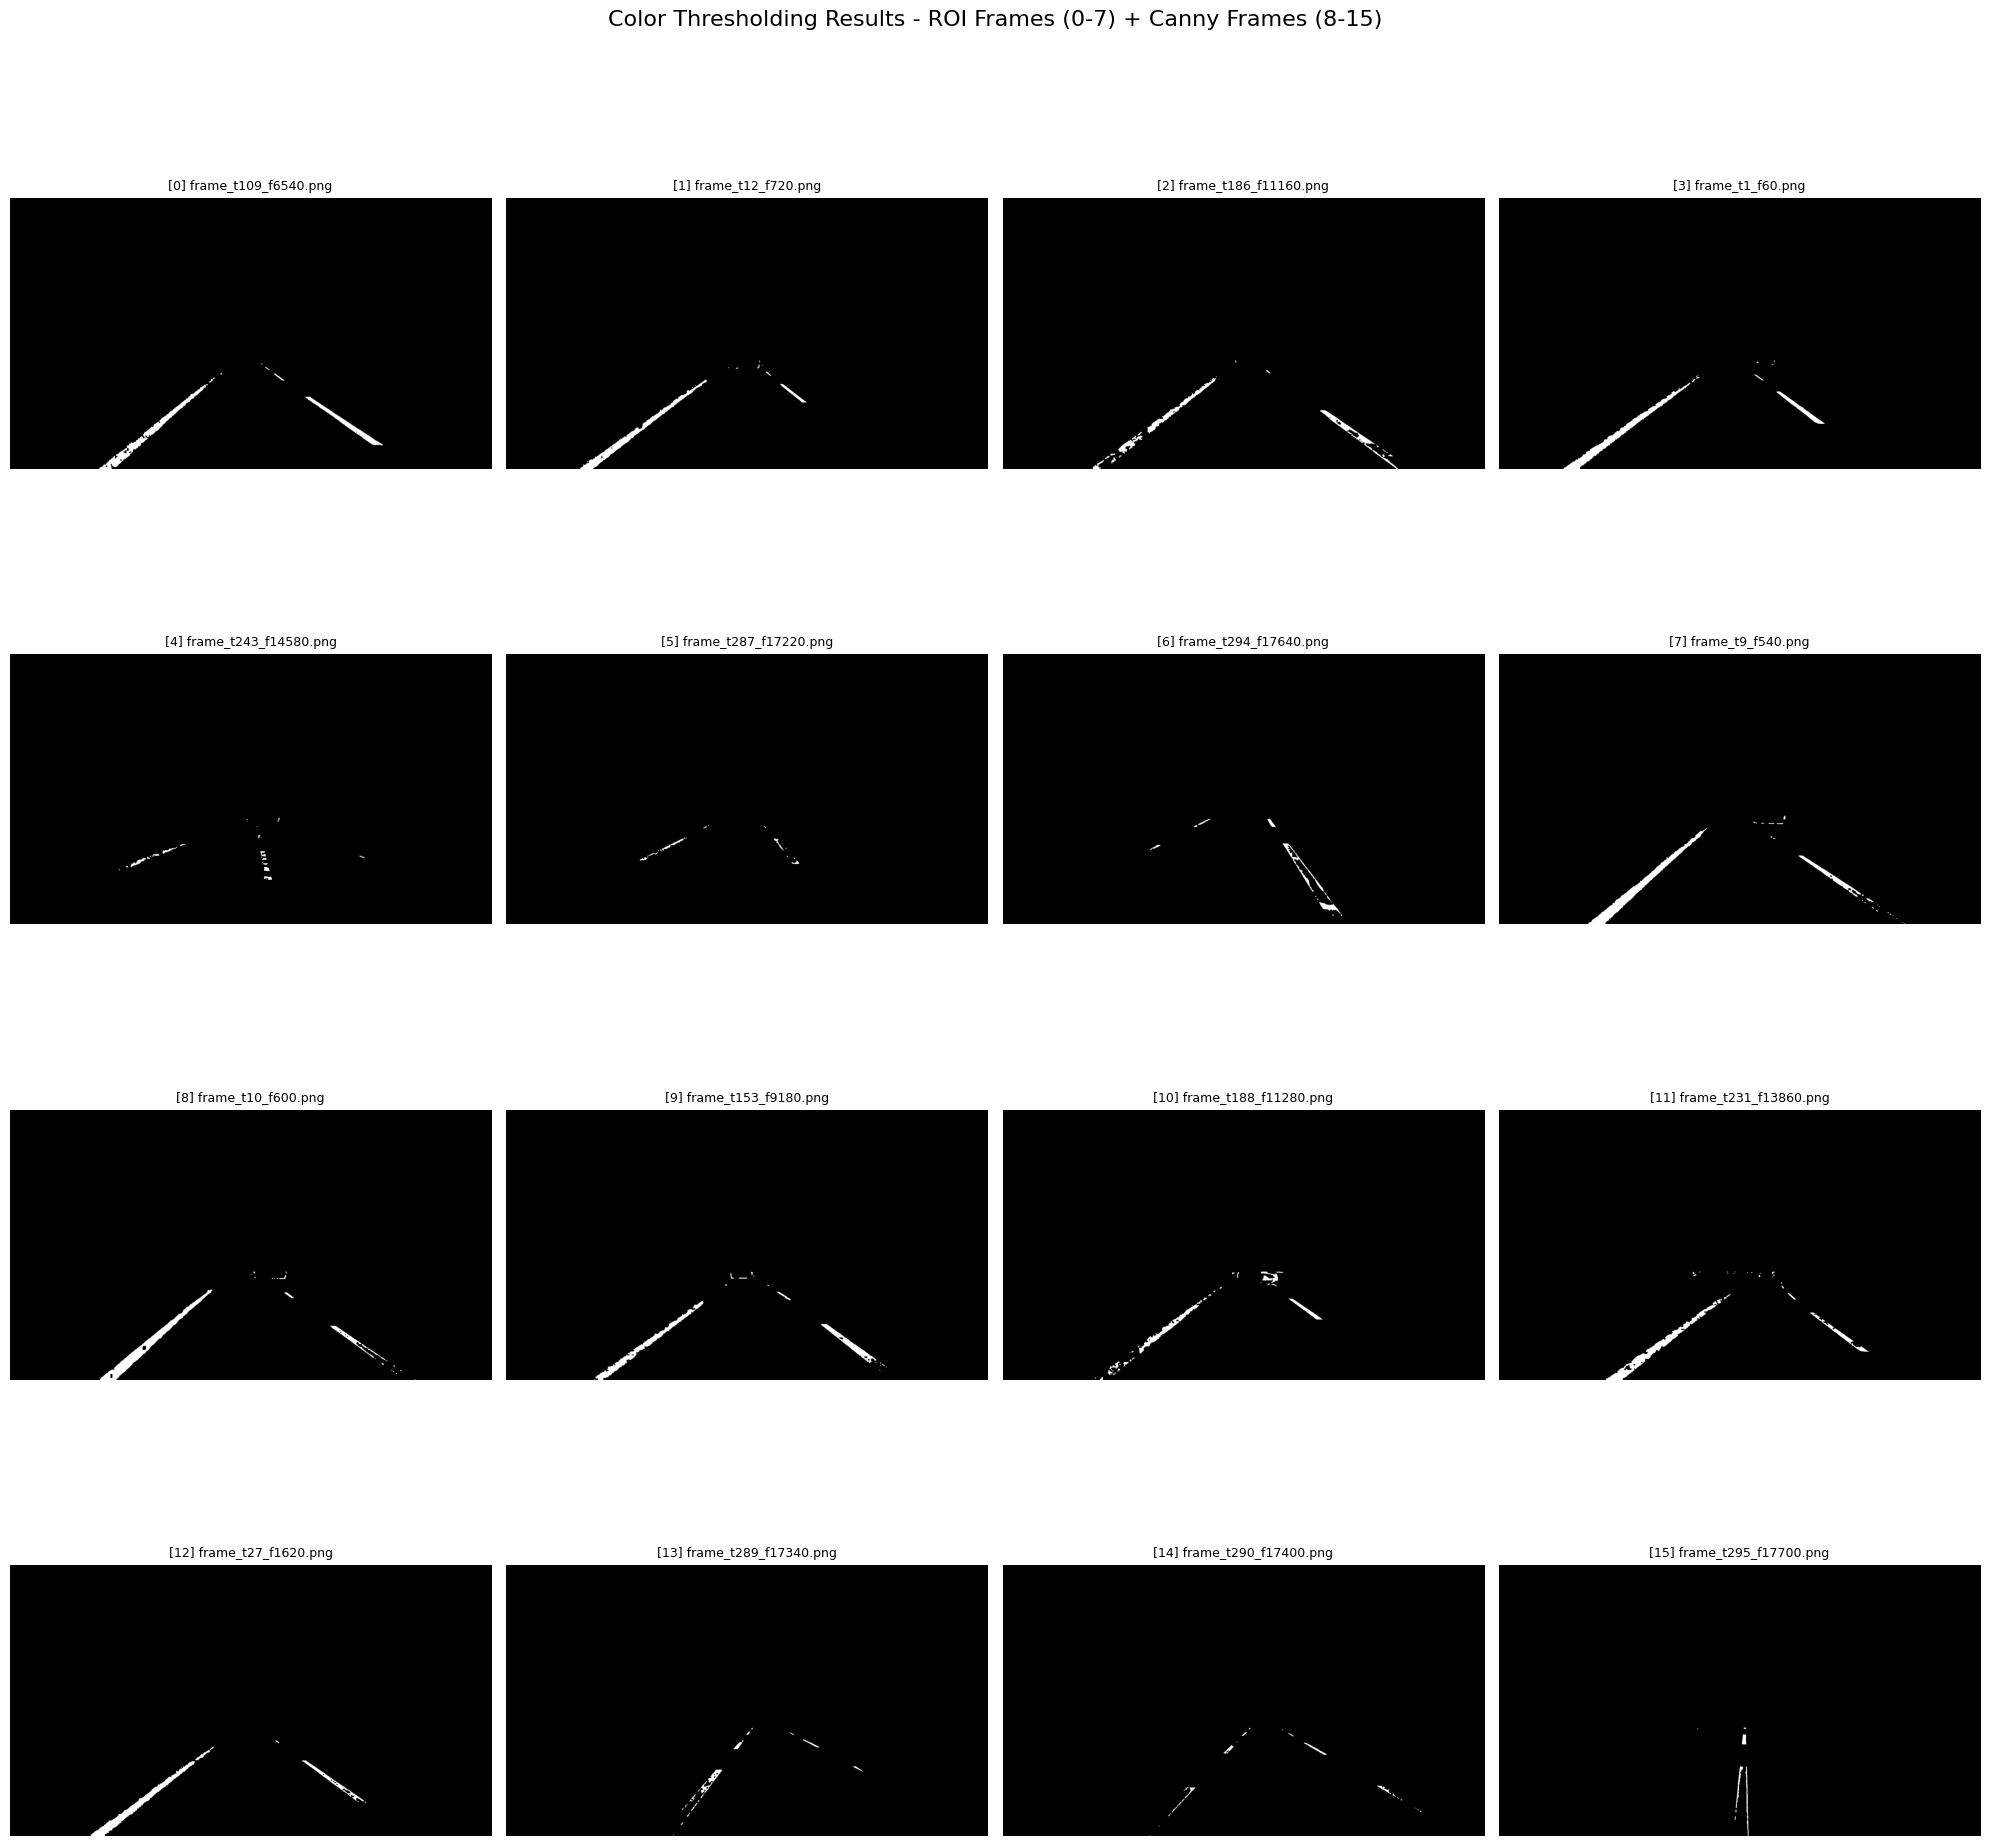

In [39]:
# Load all test frames - ROI + Canny Tuning for diverse lighting conditions
ROI_FRAME_NAMES = [
    "frame_t109_f6540.png",   # [2]
    "frame_t12_f720.png",     # [5]
    "frame_t186_f11160.png",  # [9]
    "frame_t1_f60.png",       # [12]
    "frame_t243_f14580.png",  # [18]
    "frame_t287_f17220.png",  # [23]
    "frame_t294_f17640.png",  # [29]
    "frame_t9_f540.png"       # [35]
]

CANNY_FRAME_NAMES = [
    "frame_t10_f600.png",     # [3]
    "frame_t153_f9180.png",   # [7]
    "frame_t188_f11280.png",  # [11]
    "frame_t231_f13860.png",  # [14]
    "frame_t27_f1620.png",    # [20]
    "frame_t289_f17340.png",  # [25]
    "frame_t290_f17400.png",  # [27]
    "frame_t295_f17700.png"   # [30]
]

# Combine both sets
ALL_TEST_FRAMES = ROI_FRAME_NAMES + CANNY_FRAME_NAMES

# Import pipeline functions
from pipeline import apply_roi_mask, apply_color_threshold

def process_frame(frame):
    """Apply complete color thresholding pipeline using src/pipeline.py"""
    frame_roi, _ = apply_roi_mask(frame)
    mask = apply_color_threshold(frame_roi)
    return mask

# Process all frames
rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
axes = axes.flatten()

for idx, name in enumerate(ALL_TEST_FRAMES):
    frame_path = os.path.join(frames_dir, name)
    frame = cv2.imread(frame_path)
    
    if frame is None:
        # If frame cannot be loaded, display error message
        axes[idx].text(0.5, 0.5, f"File not found:\n{name}", 
                      ha='center', va='center', fontsize=8, color='red')
        axes[idx].set_title(f"[{idx}] {name}", fontsize=9)
        axes[idx].axis("off")
        continue
    
    mask = process_frame(frame)
    
    # Display mask only
    axes[idx].imshow(mask, cmap="gray")
    axes[idx].set_title(f"[{idx}] {name}", fontsize=9)
    axes[idx].axis("off")

plt.suptitle("Color Thresholding Results - ROI Frames (0-7) + Canny Frames (8-15)", fontsize=16, y=0.995)
plt.tight_layout()
plt.show()